## 4. Logistische Regression

Eine alternative, besser an das Klassifikationsszenario angepasste Kostenfunktion statt des MSE ist die Kostenfunktion für die logistische Regression:

$$
C = −y * log(a^L) − (1 − y) * log(1 − a^L)
$$

Damit Sie diese in Ihrem Beispiel anwenden können, müssen Sie die Ableitung $∇_{a^L} C$ berechnen und die Funktion `cost_derivative()` entsprechend abändern. Da die logistische Regression davon ausgeht, dass der Output des Netzes eine Wahrscheinlichkeit zwischen 0 und 1 ist, können wir hierfür nicht den $tanh()$ als Aktivierungsfunktion verwenden. 

Machen Sie daher Ihre Änderungen aus Aufgabe 3 rückgängig, so dass Sie wieder eine sigmoide Aktivierungsfunktion haben. In der Funktion `evaluate()` sollte natürlich statt des MSE die Kostenfunktion der logistischen Regression ausgegeben werden, um zu überprüfen, ob
tatsächlich ein Gradientenabstieg stattfindet. Weiterhin ist es nützlich, sowohl auf $C$ wie auf $∇_{a^L} C$ die Funktion `np.nan_to_num()` anzuwenden, da hier zuweilen numerische Probleme auftreten können. Auch die Lernrate muss angepasst werden: $η = 1.0$ funktioniert hier deutlich besser.

### Netzwerkparameter und Initialisierung

Das Netzwerk wird nun wieder mit den alten Netzwerkparametern aus Aufgabe 2 initialisiert jedoch mit angepasster Lernrate::

In [16]:
# Netzwerkparameter laut Aufgabenbeschreibung
mbs = 10                    # Größe des Mini-Batches
eta = 1.0                   # Lernrate eta
epochs = 150                # Anzahl der Epochen
no_hidden = 2               # Anzahl der Neuronen pro versteckter Schicht

# Anzahl der Neuronen pro Schicht (2 Eingabe, 2 versteckte Schichten mit 2 Neuronen, 1 Ausgabe)
layers = [2, no_hidden, no_hidden, 1]

num_layers = len(layers)    # Anzahl der Schichten im Netzwerk
num_layers

4

In [17]:
import numpy as np
biases = [np.random.randn(y, 1) for y in layers[1:]]                        # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(layers[:-1], layers[1:])]  # Gewichte

### Datensätze generieren

In [18]:
import numpy as np

from auxiliary import get_labels, build_design_matrix

# Erstellen der Datenpunkte im vorgegebenen Bereich für Training und Test
X_train = np.random.uniform(-6, 6, (200, 2))
X_test = np.random.uniform(-6, 6, (200, 2))

# Generieren der Labels für Trainings- und Testdaten
y_train = get_labels(X_train)
y_test = get_labels(X_test)

# Erstellen der initialen Gewichtungsvektoren
w_x = np.array([1, 0])
w_y = np.array([0, 1])

xv = np.linspace(-6, 6, 100)
yv = np.linspace(-6, 6, 100)

X, Y = np.meshgrid(xv, yv)

design = np.c_[X.ravel(), Y.ravel()]

design_X_train  = build_design_matrix(X_train, w_x, w_y)
design_X_test   = build_design_matrix(X_test, w_x, w_y)

### Angepasste Aktivierungsfunktion

Wie beschrieben müssen die Änderungen aus [Aufgabe 2](exercise_1_2.ipynb) rückgängig gemacht werden so das wieder die sigmoide Aktivierungsfunktion verwendet wird.

In [19]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """Now it is the sigmoid function again :)"""
    return 1.0/(1.0+np.exp(-z))
    
# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

#### Angepasste Kostenfunktion

Zusätzlich soll in dieser Aufgabe die Kostenfunktion für die logistische Regression verwendet werden:

$$
C = −y * log(a^L) − (1 − y) * log(1 − a^L)
$$

Hierzu muss die Ableitung $∇_{a^L} C$ berechnet und die Funktion `cost_derivative()` entsprechend abgeändert werden.

Die Ableitung der logistischen Kostenfunktion nach den Ausgaben lautet:

$$
\frac{\partial C}{\partial a^L} =-\frac{y}{a^L} + \frac{1-y}{1-a}
$$

dies lässt sich noch weiter umformen zu:

$$
\frac{\partial C}{\partial a^L} = \frac{a^L - y}{a^L (1 - a^L)}
$$

Die Funktion `cost` & `cost_derivative()` kann somit wie folgt implementiert werden:

In [20]:
def cost(output_activations, y):
    """Return the cross-entropy cost."""
    # Cost function for logistic regression with C = −y * log(a^L) − (1 − y) * log(1 − a^L)
    print(f"output_activations: {output_activations}, y: {y}")
    return np.nan_to_num(-y * np.log(output_activations) - (1 - y) * np.log(1 - output_activations))

In [21]:
def cost_derivative(output_activations, y):
    # Numerische Stabilität: vermeide Division durch 0 mit np.nan_to_num
    return np.nan_to_num((output_activations - y) / (output_activations * (1.0 - output_activations)))

##### &#9432; Warum passt diese Kostenfunktion besser?

Wie bereits in der Aufgabe [1.2](exercise_1_2.ipynb) beschrieben, handelt es sich bei $a^L$ um die Ausgabe des Netzwerks (also die Aktivierung der letzten Schicht). Durch die sigmoide Aktivierungsfunktion liegen die Werte von $a^L$ entsprechend im Intervall [0, 1] und kann somit als Wahrscheinlichkeit $P(y = 1 | x) interpretiert werden. Das Modell gibt also die Wahrscheinlichkeit an, dass die Eingabe $x$ zur Klasse $y = 1$ gehört.

Der mehrwert der logistischen Kostenfunktion gegenüber dem MSE liegt in Ihrem Aufbau begründet denn die logistische Kostenfunktion besteht aus zwei Termen die jeweils für die zwei möglichen Klassen (0 und 1) verantwortlich sind.

$$
C = \color{red}{−y * log(a^L)} − \color{blue}{(1 − y) * log(1 − a^L)} \text{   \color{red}{Teil 1} \color{blue}{\text{Teil 2}}}
$$


##### &#9432; Teil 1: Gilt wenn das wahre Label $y = 1$ ist:
$$
C = -y \cdot log(a^L)
$$
Angenommen das wahre Label ist y = 1, dann vereinfacht sich die Kostenfunktion zu $C = -log(a^L)$. In diesem Fall wird die Kostenfunktion umso kleiner, je näher $a^L$ an 1 liegt (also je sicherer das Modell ist, dass die Eingabe zur Klasse 1 gehört). Wenn $a^L$ nahe bei 0 liegt, wird der Kostenwert sehr groß, was eine starke Strafe für falsche Vorhersagen darstellt.



##### &#9432; Teil 2: Gilt wenn das wahre Label $y = 0$ ist:
$$
C = -(1 - y) \cdot log(1 - a^L)
$$
Angenommen das wahre Label ist y = 0, dann vereinfacht sich die Kostenfunktion zu $C = -log(1 - a^L)$. In diesem Fall wird die Kostenfunktion umso kleiner, je näher $a^L$ an 0 liegt (also je sicherer das Modell ist, dass die Eingabe zur Klasse 0 gehört). Wenn $a^L$ nahe bei 1 liegt, wird der Kostenwert sehr groß, was wiederum eine starke Strafe für falsche Vorhersagen darstellt.


##### &#9432; Was wäre wenn x = 1 und y = 1 ist?
Wenn $x = 1$ und $y = 1$ ist wäre $\frac{\partial C}{\partial a^L} = \frac{1 - 1}{1 * (1 - 1)} = \frac{0}{0}$, also undefiniert. Daher ist es sinnvoll, sowohl auf $C$ wie auf $∇_{a^L} C$ die Funktion `np.nan_to_num()` anzuwenden, um numerische Probleme zu vermeiden.

##### &#9432; Warum ist das Verfahren dennoch nummerisch stabil?

Das Verfahren ist auch in der Theorie nummerisch stabil, da die sigmoide Aktivierungsfunktion $a^L = σ(z)$ die Ausgaben $a^L$ immer strikt im Intervall (0, 1) hält. Das bedeutet, dass $a^L$ nur 0 oder 1 annimmt, wenn $z$ gegen $-∞$ bzw. $+∞$ geht, was in der Praxis nicht möglich ist. Daher wird $a^L$ niemals exakt 0 oder 1 sein, sondern nur sehr nahe daran. Dies verhindert, dass die Division durch Null in der Ableitung der Kostenfunktion auftritt, da sowohl $a^L$ als auch $(1 - a^L)$ immer positive Werte sind.

> **Hinweis:** $a^L$ ist der Startpunkt für den Backpropagation-Algorithmus. $a^L$ sind die Aktivierungen der letzten Schicht. Bei Softmax (also mehrklassiger Klassifikation) wäre $a^L$ ein Vektor, dessen Komponenten $a_k^L$ die Klassenwahrscheinlichkeit darstellt.

##### &#9432; Beispiel mit genutzter Kostenfunktion
Wie in Aufgabe [1.2](exercise_1_2.ipynb) soll dieser Effekt an einem kleinen rechnerischen Beispiel verdeutlicht werden. Betrachten wir wieder die gleiche Situation wie in Aufgabe 1.2, jedoch mit der logistischen Kostenfunktion:

- $z^L = -4$ (also eine sehr schlechte Vorhersage des Modells)
- $y = 1$ (das wahre Label)
- $w^L = 0.5$ (Gewicht der letzten Schicht)
- $\eta = 1.0$ (Lernrate)

**1. Vorwärtsdurchlauf:**

Mit der gegebenen Aktivierungsfunktion (sigmoid) berechnen wir die Ausgabe des Netzwerks:
$$
a^L = σ(z^L) = \frac{1}{1 + e^{-(-4)}} \approx 0.01799
$$

**2. Kostenberechnung:**

Nun berechnen wir die Kosten mit der logistischen Kostenfunktion:
$$
C = -y \cdot log(a^L) - (1 - y) \cdot log(1 - a^L) = -1 \cdot log(0.01799) - 0 \cdot log(1 - 0.01799) \approx 4.017
$$

&#8594; Die Kosten sind hier deutlich höher als im MSE-Beispiel, was die starke Abweichung der Vorhersage vom wahren Label widerspiegelt. Dies ist soweit aber normal, entscheidend ist der Gradient.

**3. Backpropagation berechnet den Gradienten:**

Der Gradient der Kostenfunktion bezüglich der Ausgabe $a^L$ ist:
$$
\frac{\partial C}{\partial a^L} = \frac{a^L - y}{a^L (1 - a^L)} = \frac{0.01799 - 1}{0.01799 \cdot (1 - 0.01799)} \approx -54.93
$$

Der Gradient bezüglich der Aktivierung $z^L$ ist:
$$
\frac{\partial C}{\partial z^L} = \frac{\partial C}{\partial a^L} \cdot σ'(z^L) = -54.93 \cdot (0.01799 \cdot (1 - 0.01799)) \approx -0.967
$$

Der Gradient bezüglich des gewichteten Inputs ist:
$$
\frac{\partial C}{\partial w^L} = \frac{\partial C}{\partial z^L} \cdot a^{L-1} = -0.967 \cdot a^{L-1}
$$

**4. Gewichtsaktualisierung:**
Die Gewichtsaktualisierung erfolgt dann durch:
$$
w^L = w^L - \eta \cdot \frac{\partial C}{\partial w^L} = 0.5 - 1.0 \cdot (-0.967 \cdot a^{L-1}) = 0.5 + 0.967 \cdot a^{L-1}
$$
Angenommen $a^{L-1} = 1$ für dieses Beispiel, dann:
$$
w^L = 0.5 + 0.967 \cdot 1 = 1.467
$$
Durch die Verwendung der logistischen Kostenfunktion wird der Gradient deutlich größer, was zu einer stärkeren Anpassung der Gewichte führt. Dies zeigt, dass die logistische Kostenfunktion besser auf die Anforderungen eines Klassifikationsproblems abgestimmt ist, indem sie größere Strafen für falsche Vorhersagen verhängt und somit effektivere Lernschritte ermöglicht.

### Feedforward

In [22]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

### Evaluate

In [23]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0     # Anzahl korrekt klassifizierter Testbeispiele
    loss    = []    # Liste zur Speicherung der Verluste (Erweiterung laut Aufgabenbeschreibung)
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        # 
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()

        # Korrektes Label erhalten
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Die Vorhersage ist 1, wenn die Ausgabe >= 0.5 ist, sonst 0
        cpred = 1 if ypred >= 0.5 else 0

        c = y
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1

        # Loss berechnen und speichern
        loss.append(cost(ypred, y)) # Costfunction logistic regression
        
    return correct, np.mean(loss)

### Backpropagation-Algorithmus

In [24]:
def backprop(x, y):
    """Return a tuple ``(\nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

### Minibatches

In [25]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

### Stochastischer Gradientenabstieg (SGD)

In [26]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    precision_curve = []  # Liste zur Speicherung der Präzisionswerte (Erweiterung laut Aufgabenbeschreibung)
    mse_curve = []        # Liste zur Speicherung der MSE-Werte (Erweiterung laut Aufgabenbeschreibung)

    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    print("| Epochs | Precision | Loss   |")
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j], loss = evaluate(x2, y2)

        precision_curve.append(acc_val[j] / n_test)  # Präzisionswert speichern
        mse_curve.append(loss)              # MSE-Wert speichern

        if j % 10 == 0 or j == epochs - 1:
            print("|  {:>5} |   {:>6.4f}  | {:>6.4f} |".format(j+1, precision_curve[-1], mse_curve[-1]))
    
    return acc_val, precision_curve, mse_curve

### Training des Netzwerk

In [27]:
acc_val, precision, loss = SGD(design_X_train, y_train, epochs, mbs, eta, X_test, y_test)

| Epochs | Precision | Loss   |
output_activations: [[0.64024091]], y: 0
output_activations: [[0.64524255]], y: 0
output_activations: [[0.65859024]], y: 1
output_activations: [[0.59298792]], y: 0
output_activations: [[0.64283558]], y: 1
output_activations: [[0.60469048]], y: 0
output_activations: [[0.59602473]], y: 0
output_activations: [[0.65249859]], y: 1
output_activations: [[0.64586837]], y: 0
output_activations: [[0.64014159]], y: 0
output_activations: [[0.58518968]], y: 1
output_activations: [[0.58381562]], y: 1
output_activations: [[0.63378691]], y: 0
output_activations: [[0.65098223]], y: 0
output_activations: [[0.58380189]], y: 1
output_activations: [[0.60697805]], y: 0
output_activations: [[0.58482433]], y: 1
output_activations: [[0.59482252]], y: 0
output_activations: [[0.58422596]], y: 1
output_activations: [[0.66023171]], y: 1
output_activations: [[0.58899758]], y: 0
output_activations: [[0.58958721]], y: 0
output_activations: [[0.58378863]], y: 1
output_activations: [[0.6

In [28]:
print("Shape of precision array:", np.array(precision).shape)
print("Shape of loss array:", np.array(loss).shape)

Shape of precision array: (150,)
Shape of loss array: (150,)


### Darstellung der Lernkurven

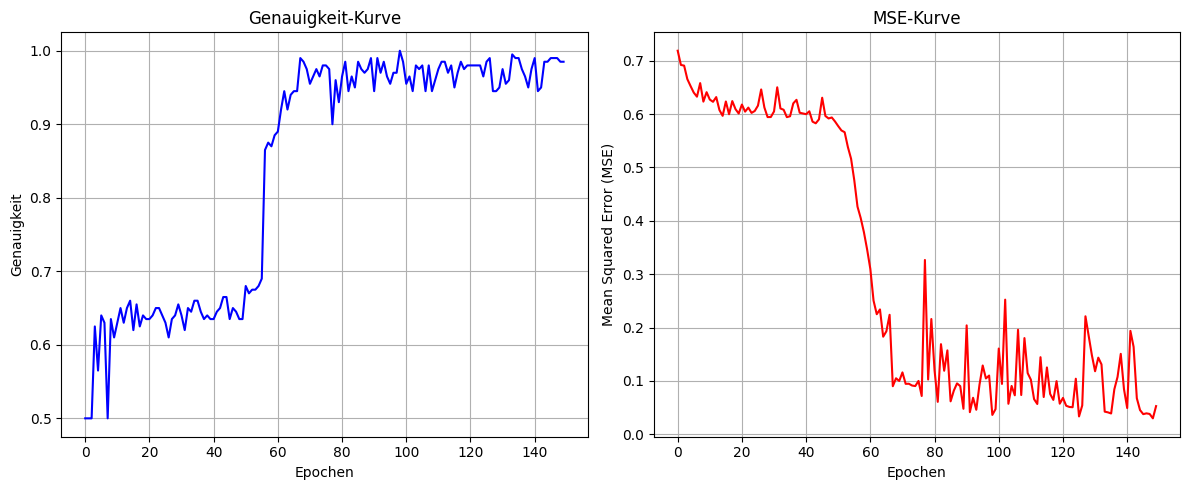

In [29]:
from matplotlib import pyplot as plt

### Darstellen der Lernkurven
# Genauigkeit-Kurve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), precision, label='Genauigkeit', color='blue')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit-Kurve')
plt.grid()
# MSE-Kurve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='MSE', color='red')
plt.xlabel('Epochen')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE-Kurve')
plt.grid()
plt.tight_layout()
plt.show()

### Entscheidungsgrenzen visualisieren

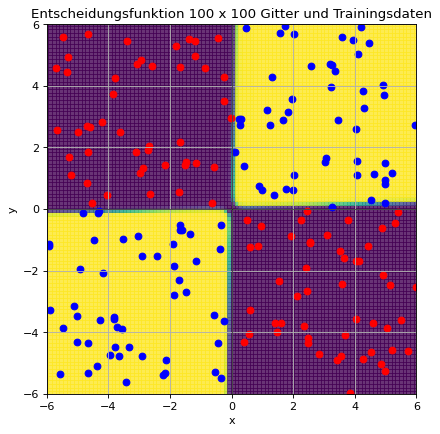

In [30]:
mlp_design_decision = feedforward(design.T)

figure, axis = plt.subplots(1, 1, figsize=(6, 6), dpi=80)
axis_limits = [-6, 6]

# Plot der Entscheidungsfunktion
axis.pcolor(X, Y, mlp_design_decision.reshape(100,100), alpha=.8)
axis.grid(True)
axis.set_title("Entscheidungsfunktion 100 x 100 Gitter und Trainingsdaten")
axis.set_xlabel("x")
axis.set_ylabel("y")
axis.axhline(0, color='black', linewidth=0.5)
axis.axvline(0, color='black', linewidth=0.5)
axis.set_xlim(axis_limits)
axis.set_ylim(axis_limits)
axis.set_aspect('equal')

# Scatter-Plot der Labels
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Label 1')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='Label 0')

plt.show()